In [5]:
!pip install kmodes

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes

In [7]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [75]:
df = pd.read_csv('drive/MyDrive/UPS/user_profiles_for_ads.csv')

In [76]:
df.head()

,User ID,Age,Gender,Location,Language,Education Level,Likes and Reactions,Followed Accounts,Device Usage,Time Spent Online (hrs/weekday),Time Spent Online (hrs/weekend),Click-Through Rates (CTR),Conversion Rates,Ad Interaction Time (sec),Income Level,Top Interests
0,1,25-34,Female,Suburban,Hindi,Technical,5640,190,Mobile Only,4.5,1.7,0.193,0.067,25,20k-40k,Digital Marketing
1,2,65+,Male,Urban,Hindi,PhD,9501,375,Tablet,0.5,7.7,0.114,0.044,68,0-20k,Data Science
2,3,45-54,Female,Suburban,Spanish,Technical,4775,187,Mobile Only,4.5,5.6,0.153,0.095,80,60k-80k,Fitness and Wellness
3,4,35-44,Female,Rural,Spanish,PhD,9182,152,Desktop Only,3.1,4.2,0.093,0.061,65,100k+,"Gaming, DIY Crafts"
4,5,25-34,Female,Urban,English,Technical,6848,371,Mobile Only,2.0,3.8,0.175,0.022,99,20k-40k,"Fitness and Wellness, Investing and Finance, G..."


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   User ID                          1000 non-null   int64  
 1   Age                              1000 non-null   object 
 2   Gender                           1000 non-null   object 
 3   Location                         1000 non-null   object 
 4   Language                         1000 non-null   object 
 5   Education Level                  1000 non-null   object 
 6   Likes and Reactions              1000 non-null   int64  
 7   Followed Accounts                1000 non-null   int64  
 8   Device Usage                     1000 non-null   object 
 9   Time Spent Online (hrs/weekday)  1000 non-null   float64
 10  Time Spent Online (hrs/weekend)  1000 non-null   float64
 11  Click-Through Rates (CTR)        1000 non-null   float64
 12  Conversion Rates     

In [78]:
df.describe()

,User ID,Likes and Reactions,Followed Accounts,Time Spent Online (hrs/weekday),Time Spent Online (hrs/weekend),Click-Through Rates (CTR),Conversion Rates,Ad Interaction Time (sec)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,4997.084000,251.438000,2.757500,4.601600,0.125333,0.049805,91.425000
std,288.819436,2838.494365,141.941557,1.279735,2.026234,0.071187,0.028670,51.497965
min,1.000000,101.000000,10.000000,0.500000,1.000000,0.000000,0.000000,5.000000
25%,250.750000,2661.250000,126.000000,1.700000,2.900000,0.065000,0.026000,45.750000
50%,500.500000,5002.500000,245.500000,2.800000,4.700000,0.128000,0.049000,90.000000
75%,750.250000,7348.750000,377.000000,3.800000,6.400000,0.186000,0.073000,137.250000
max,1000.000000,9973.000000,498.000000,5.000000,8.000000,0.250000,0.100000,179.000000


In [79]:
# just don't like the naming, make them lowercase, replace the space with underscore, remove parentheses, replace / to _per_
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('[()]', '', regex=True).str.replace('/', '_per_')

In [80]:
# Split the 'top_interests' column and get all unique interests
all_interests = df['top_interests'].str.split(', ').explode().unique()

# Display the unique interests and their count
print("Unique interests:")
display(all_interests)
print(f"\nTotal number of unique interests: {len(all_interests)}")

Unique interests:


array(['Digital Marketing', 'Data Science', 'Fitness and Wellness',
       'Gaming', 'DIY Crafts', 'Investing and Finance', 'Gardening',
       'Music Production', 'Gourmet Cooking', 'Software Engineering',
       'Eco-Friendly Living', 'Photography', 'Travel and Adventure',
       'Fashion Modelling', 'Reading and Literature', 'Pet Care'],
      dtype=object)


Total number of unique interests: 16


In [81]:
# Function to count the number of interests
def count_interests(interests_string):
    if isinstance(interests_string, str):
        # Split the string by comma and count the number of interests
        return len([interest.strip() for interest in interests_string.split(',') if interest.strip()])
    return 0

# Apply the function to the 'top_interests' column to create a new column
df['num_interests'] = df['top_interests'].apply(count_interests)

In [82]:
_interests = {}
for k in all_interests:
  a = k.lower().replace(' ', '_')
  _interests[a] = k

In [83]:
new_columns_df = pd.DataFrame(
    {
        key: df['top_interests'].str.contains(value, na=False) for key, value in _interests.items()
    }
)

new_columns_df = new_columns_df.astype(int)
new_columns_df.columns = new_columns_df.columns.str.replace('-', '_')

In [84]:
df = pd.concat([df, new_columns_df], axis=1)

In [85]:
# Get categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Print unique values for each categorical column
for col in categorical_cols:
  print(f"Column '{col}': {df[col].nunique()} unique values")

Column 'age': 6 unique values
Column 'gender': 2 unique values
Column 'location': 3 unique values
Column 'language': 4 unique values
Column 'education_level': 5 unique values
Column 'device_usage': 4 unique values
Column 'income_level': 6 unique values
Column 'top_interests': 680 unique values


In [86]:
# plt.figure(figsize=(8, 6))
# sns.countplot(x='device_usage', data=df, palette='viridis')
# plt.title('Device Usage Distribution')
# plt.xlabel('Device Usage Group')
# plt.ylabel('Count')
# plt.show()

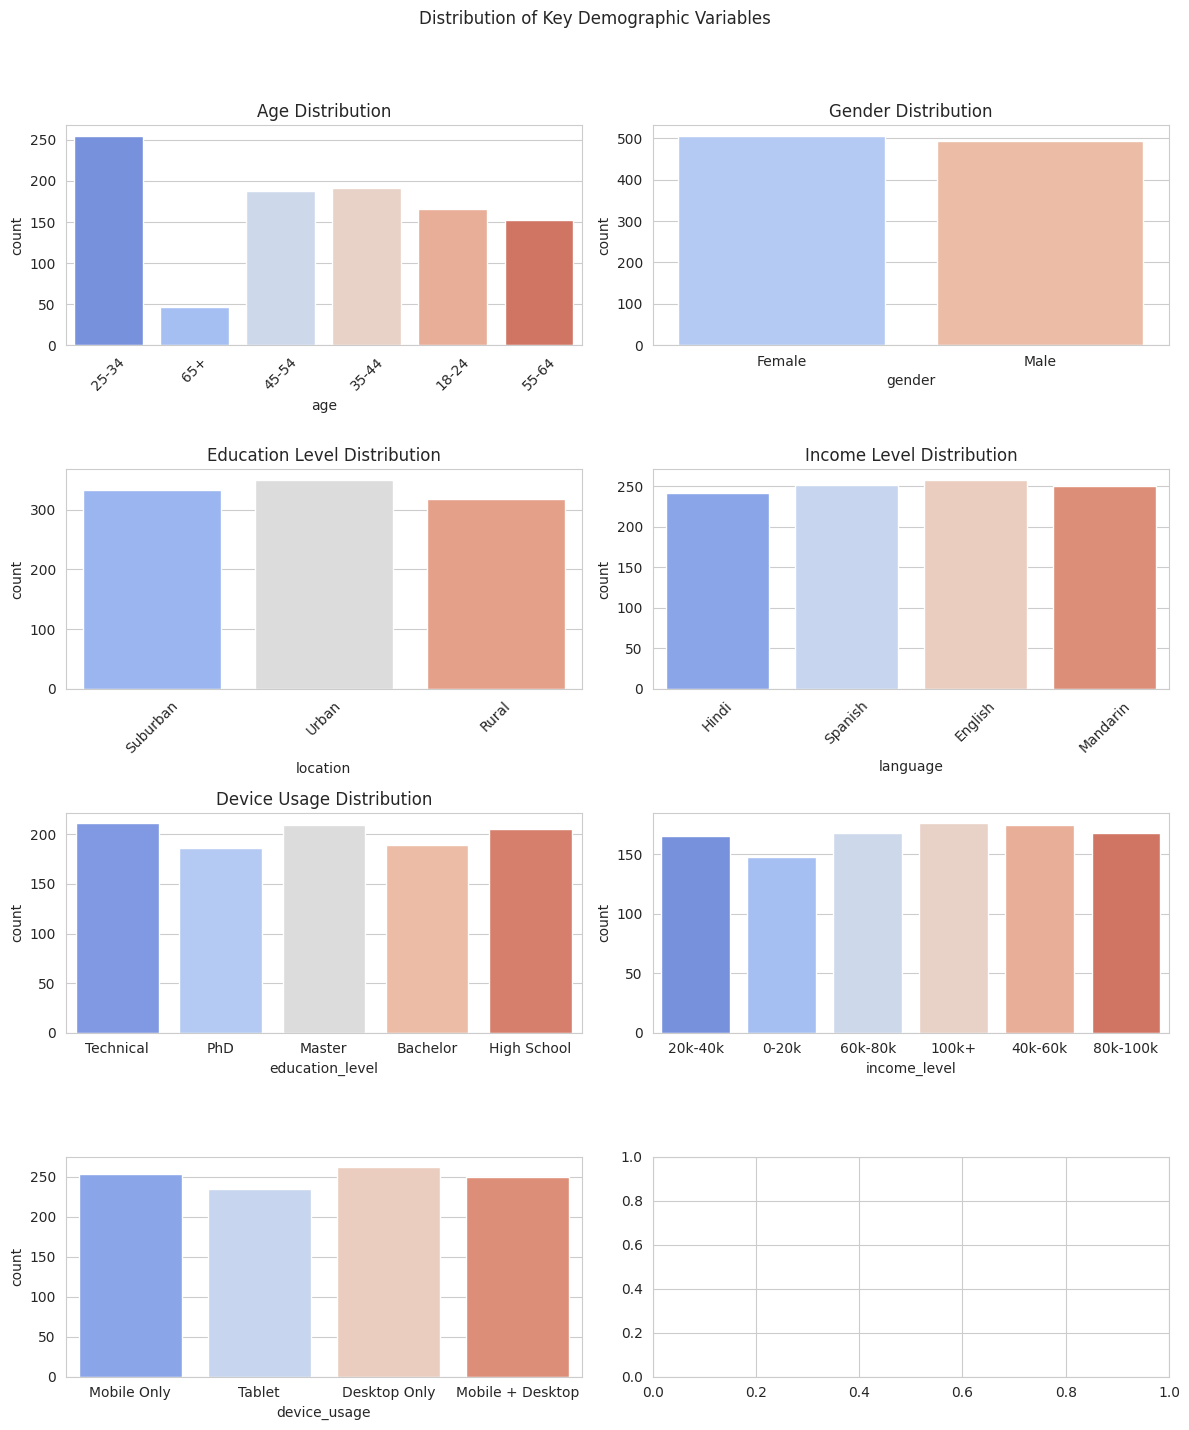

In [87]:
sns.set_style("whitegrid")

# creating subplots for the demographic distributions
fig, axes = plt.subplots(4, 2, figsize=(12, 15))
fig.suptitle('Distribution of Key Demographic Variables')

# age distribution
sns.countplot(ax=axes[0, 0], x='age', data=df, palette='coolwarm')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].tick_params(axis='x', rotation=45)

# gender distribution
sns.countplot(ax=axes[0, 1], x='gender', data=df, palette='coolwarm')
axes[0, 1].set_title('Gender Distribution')

# location distribution
sns.countplot(ax=axes[1, 0], x='location', data=df, palette='coolwarm')
axes[1, 0].set_title('Location Distribution')

# language distribution
sns.countplot(ax=axes[1, 1], x='language', data=df, palette='coolwarm')
axes[1, 1].set_title('Language Distribution')

# education level distribution
sns.countplot(ax=axes[2, 0], x='education_level', data=df, palette='coolwarm')
axes[1, 0].set_title('Education Level Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)

# income level distribution
sns.countplot(ax=axes[2, 1], x='income_level', data=df, palette='coolwarm')
axes[1, 1].set_title('Income Level Distribution')
axes[1, 1].tick_params(axis='x', rotation=45)

# Device usage distribution
sns.countplot(ax=axes[3, 0], x='device_usage', data=df, palette='coolwarm')
axes[2, 0].set_title('Device Usage Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [88]:
# plt.figure(figsize=(8, 6))
# sns.histplot(data=df, x='followed_accounts', bins=20, kde=True)
# plt.title('Ad Interaction in Sec')
# plt.xlabel('Interaction (Sec)')
# plt.ylabel('Frequency')
# plt.show()

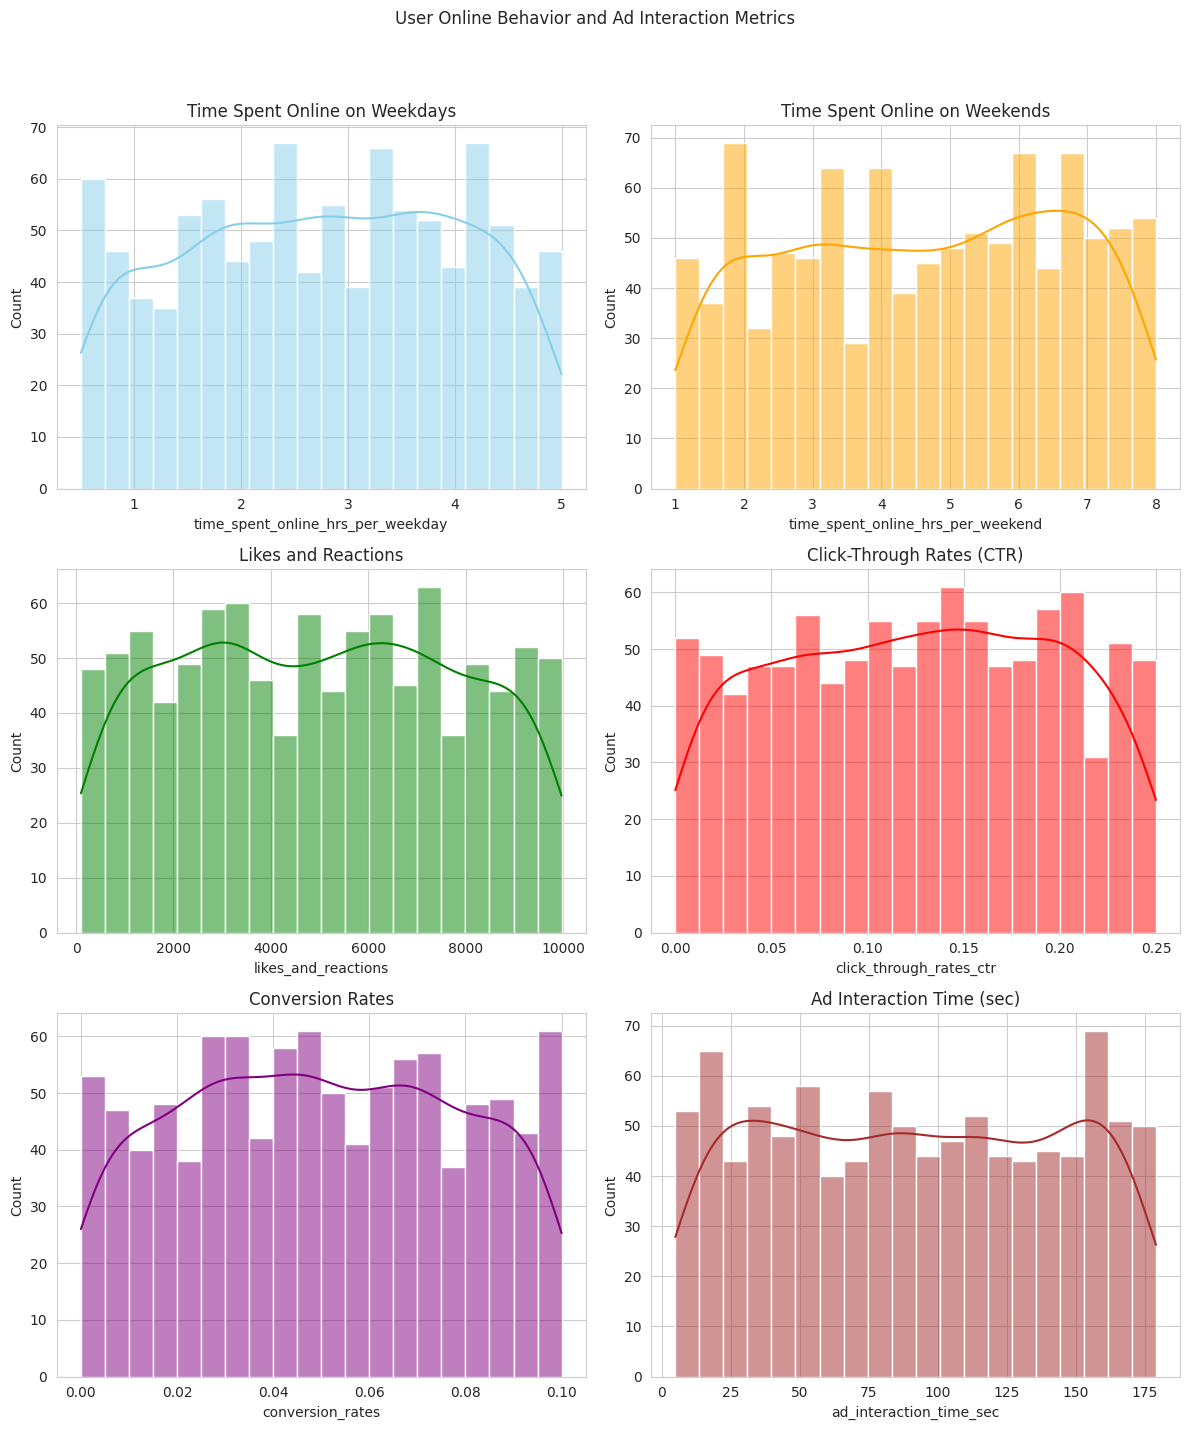

In [89]:
# distribution of users activity
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('User Online Behavior and Ad Interaction Metrics')

# time spent online on weekdays
sns.histplot(ax=axes[0, 0], x='time_spent_online_hrs_per_weekday', data=df, bins=20, kde=True, color='skyblue')
axes[0, 0].set_title('Time Spent Online on Weekdays')

# time spent online on weekends
sns.histplot(ax=axes[0, 1], x='time_spent_online_hrs_per_weekend', data=df, bins=20, kde=True, color='orange')
axes[0, 1].set_title('Time Spent Online on Weekends')

# likes and reactions
sns.histplot(ax=axes[1, 0], x='likes_and_reactions', data=df, bins=20, kde=True, color='green')
axes[1, 0].set_title('Likes and Reactions')

# click-through rates
sns.histplot(ax=axes[1, 1], x='click_through_rates_ctr', data=df, bins=20, kde=True, color='red')
axes[1, 1].set_title('Click-Through Rates (CTR)')

# conversion rates
sns.histplot(ax=axes[2, 0], x='conversion_rates', data=df, bins=20, kde=True, color='purple')
axes[2, 0].set_title('Conversion Rates')

# ad interaction time
sns.histplot(ax=axes[2, 1], x='ad_interaction_time_sec', data=df, bins=20, kde=True, color='brown')
axes[2, 1].set_title('Ad Interaction Time (sec)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

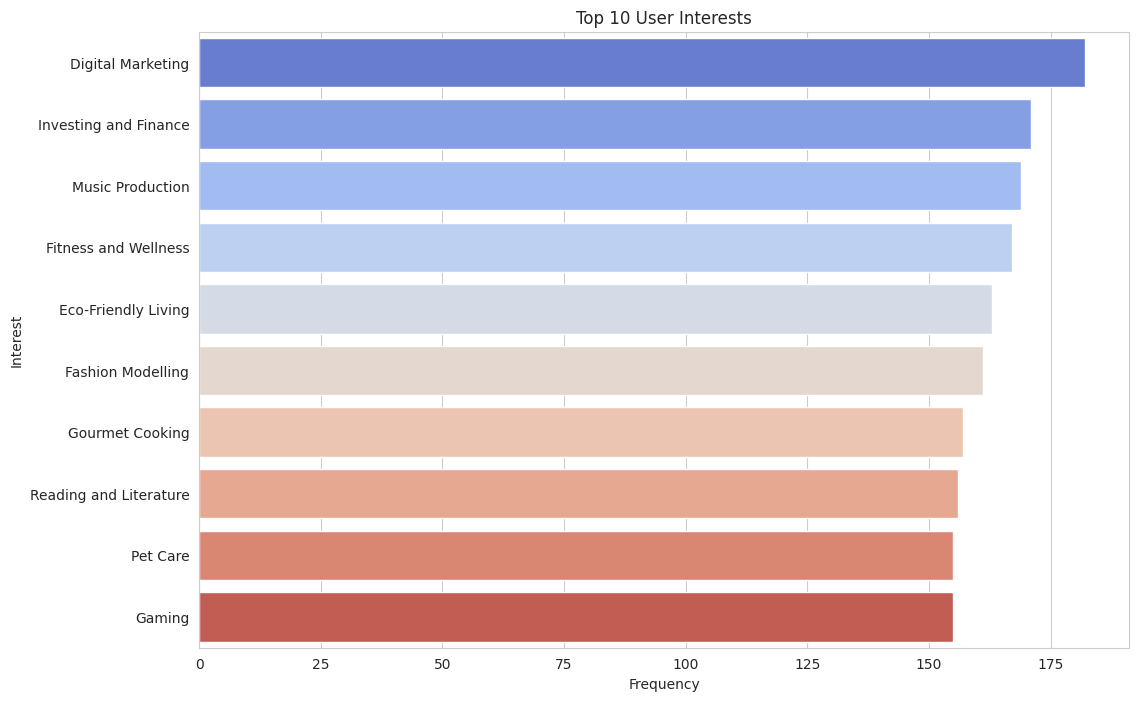

In [90]:
# Get the top 10 interests topic
# splitting the 'Top Interests' column and creating a list of all interests
interests_list = df['top_interests'].str.split(', ').sum()

# counting the frequency of each interest
interests_counter = Counter(interests_list)

# converting the counter object to a DataFrame for easier plotting
interests_df = pd.DataFrame(interests_counter.items(), columns=['Interest', 'Frequency']).sort_values(by='Frequency', ascending=False)

# plotting the most common interests
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Interest', data=interests_df.head(10), palette='coolwarm')
plt.title('Top 10 User Interests')
plt.xlabel('Frequency')
plt.ylabel('Interest')
plt.show()

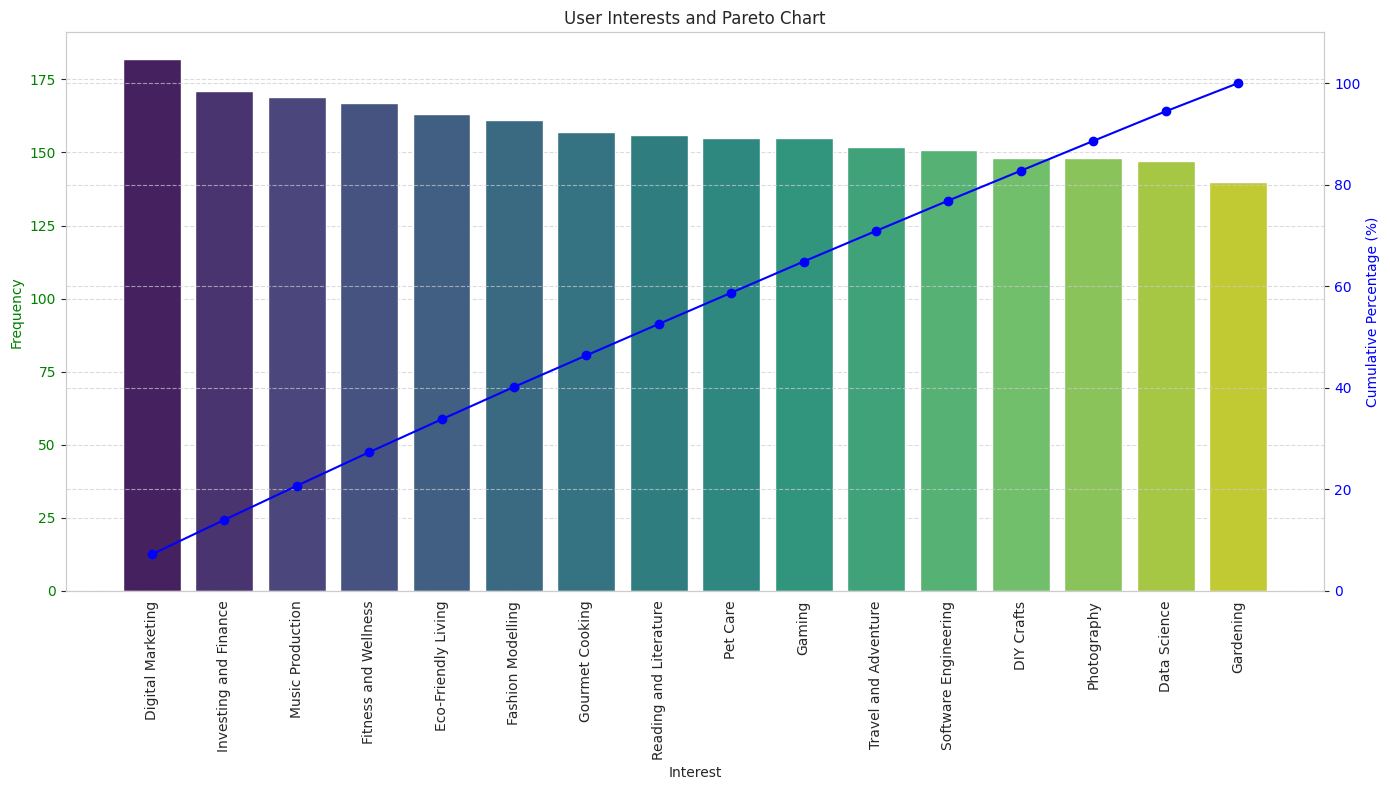

In [91]:
# Calculate cumulative percentage for Pareto chart
interests_df['cumulative_frequency'] = interests_df['Frequency'].cumsum()
interests_df['cumulative_percentage'] = interests_df['cumulative_frequency'] / interests_df['Frequency'].sum() * 100

# Plotting the vertical bar plot and Pareto chart
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot
sns.barplot(x='Interest', y='Frequency', data=interests_df, ax=ax1, palette='viridis')
ax1.set_title('User Interests and Pareto Chart')
ax1.set_xlabel('Interest')
ax1.set_ylabel('Frequency', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.tick_params(axis='x', rotation=90)

# Pareto chart line
ax2 = ax1.twinx()
ax2.plot(interests_df['Interest'], interests_df['cumulative_percentage'], color='b', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylim(0, 110) # Set y-axis limit to 110% to ensure the line is fully visible

# Add grid lines for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [92]:
df = df.drop('top_interests', axis=1)

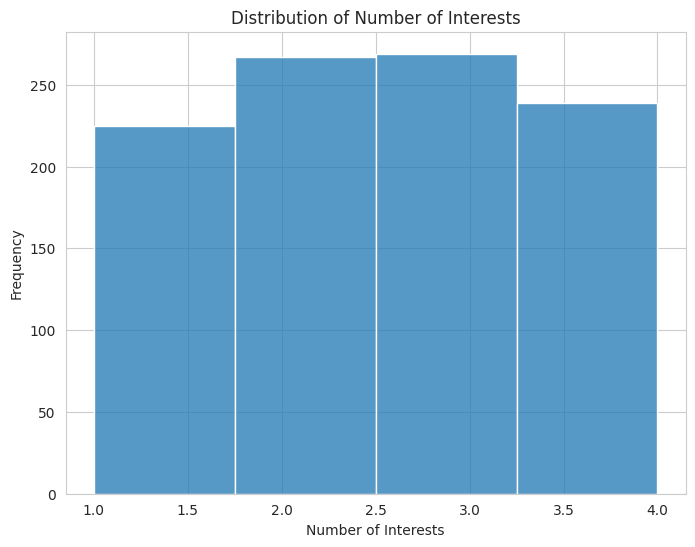

In [93]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='num_interests', bins=4)
plt.title('Distribution of Number of Interests')
plt.xlabel('Number of Interests')
plt.ylabel('Frequency')
plt.show()

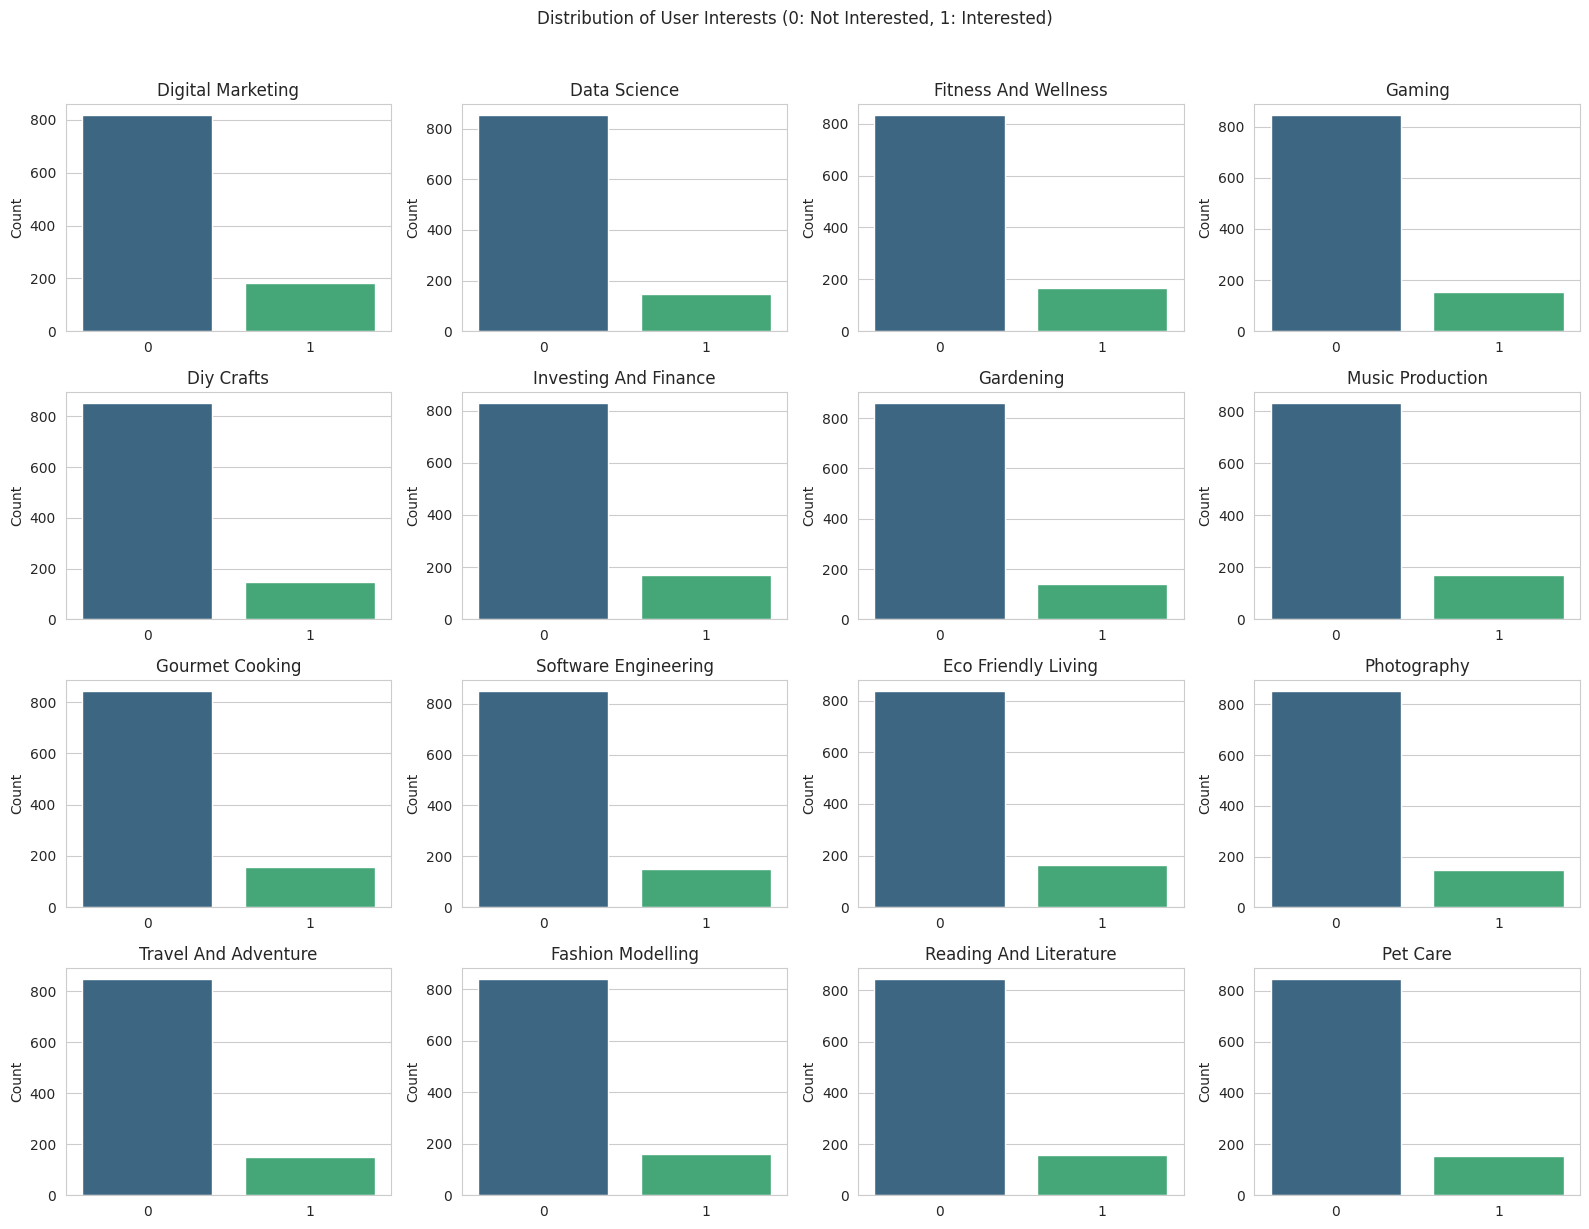

In [94]:
# Select the interest columns
interest_cols = df.columns[df.columns.get_loc('digital_marketing'):]

# Calculate the number of rows and columns for subplots
n_cols = 4
n_rows = (len(interest_cols) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
fig.suptitle('Distribution of User Interests (0: Not Interested, 1: Interested)', y=1.02)
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through each interest column and create a bar chart in a subplot
for i, col in enumerate(interest_cols):
    sns.countplot(x=col, data=df, palette='viridis', ax=axes[i])
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].set_xlabel("") # Remove x-label from individual subplots
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [95]:
# Selecting the relevant features for clustering
features = list(df.columns[1:16])

# remove features with low variance
features.remove('age')
features.remove('gender')
features.remove('language')
features.remove('device_usage')
features.remove('education_level')
features.remove('income_level')
features.remove('location')

In [96]:
features

['likes_and_reactions',
 'followed_accounts',
 'time_spent_online_hrs_per_weekday',
 'time_spent_online_hrs_per_weekend',
 'click_through_rates_ctr',
 'conversion_rates',
 'ad_interaction_time_sec',
 'num_interests']

In [97]:
X = df[features]

In [98]:
# defining preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = StandardScaler()

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder()

# combining preprocessing steps
preprocessor = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])

In [99]:
# Apply preprocessing to the features
X_processed = preprocessor.fit_transform(X)

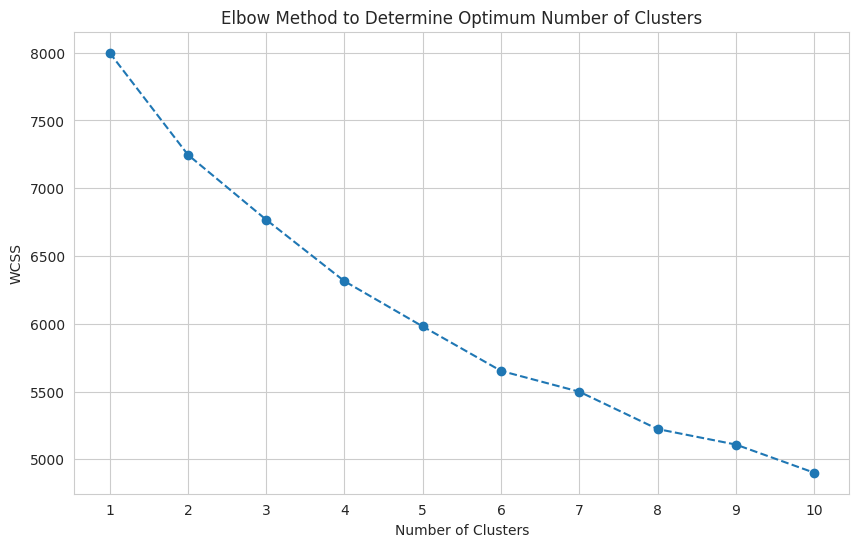

In [100]:
# Calculating WCSS for different number of clusters
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(X_processed)
  wcss.append(kmeans.inertia_)

# Plotting the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimum Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

For K = 2, the average silhouette score is 0.09264103774859737
For K = 3, the average silhouette score is 0.08284630042433502
For K = 4, the average silhouette score is 0.0912183453709378
For K = 5, the average silhouette score is 0.09330484423577388
For K = 6, the average silhouette score is 0.10001704384839476
For K = 7, the average silhouette score is 0.09545902686476732
For K = 8, the average silhouette score is 0.10341505558821423
For K = 9, the average silhouette score is 0.10008614556433228
For K = 10, the average silhouette score is 0.10480487913687055


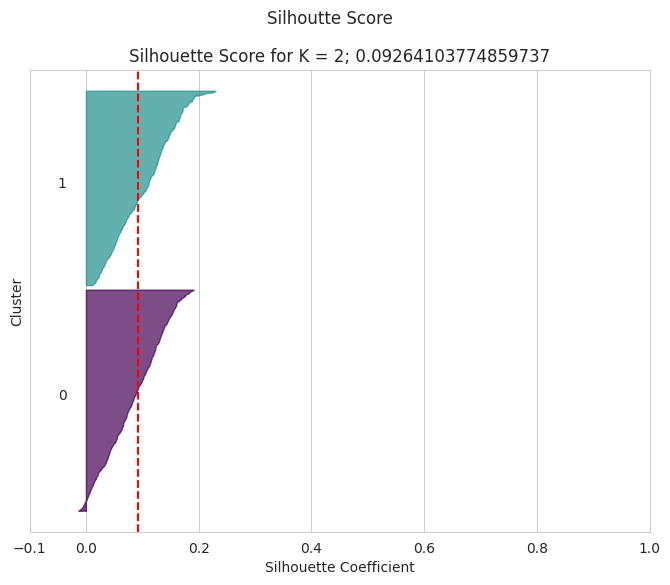

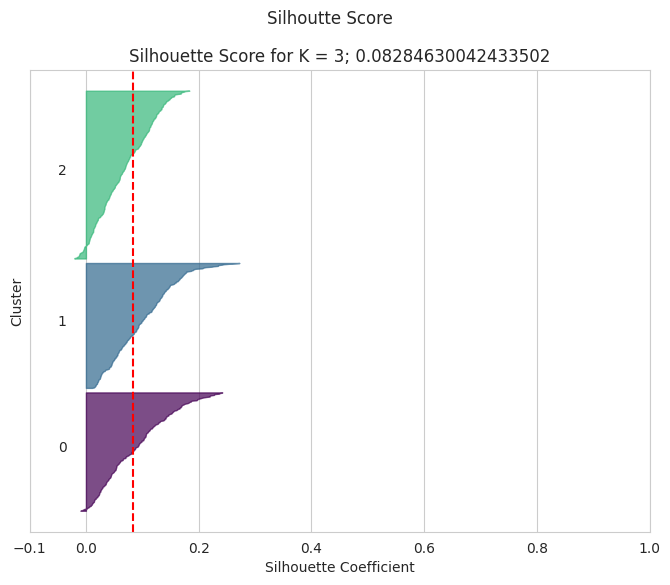

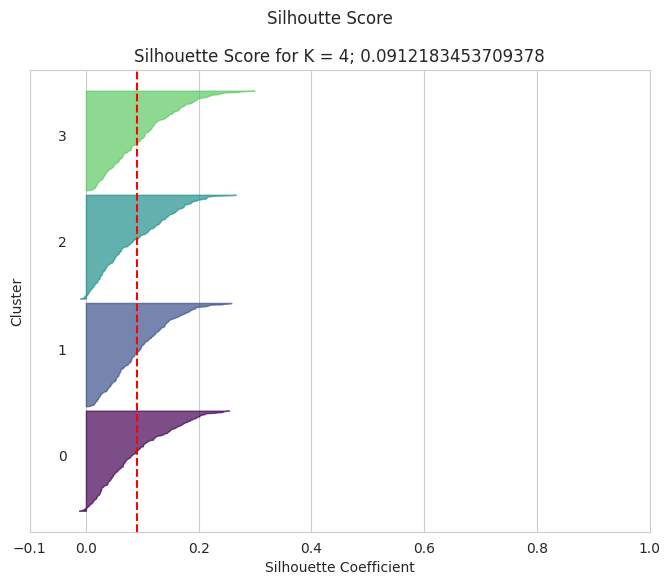

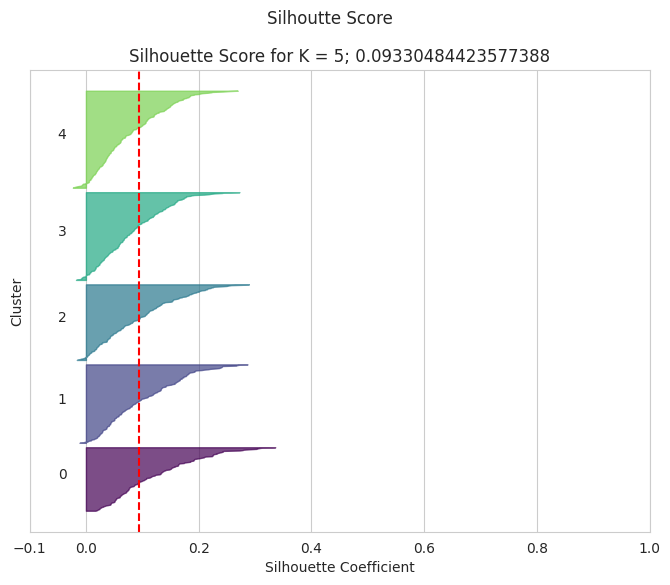

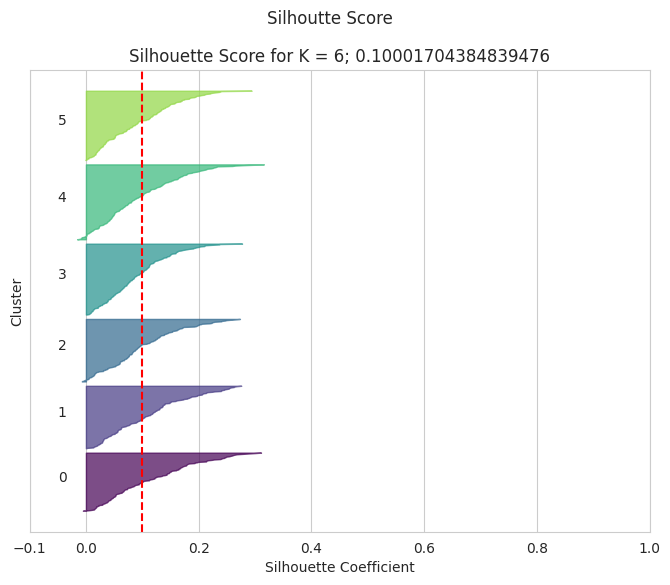

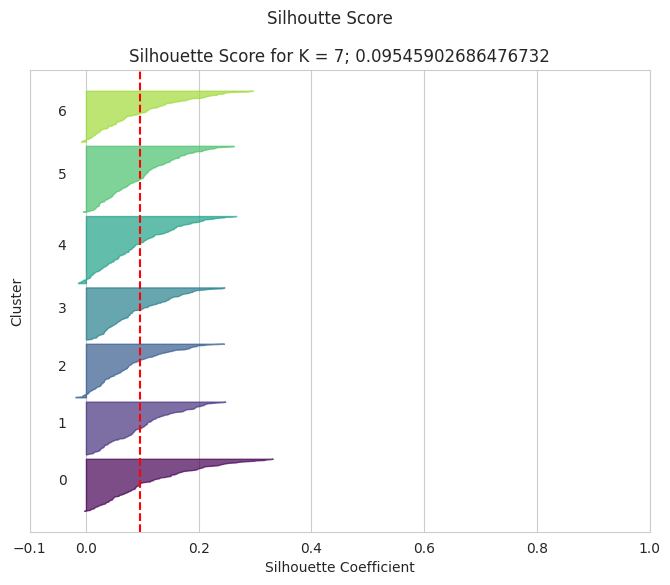

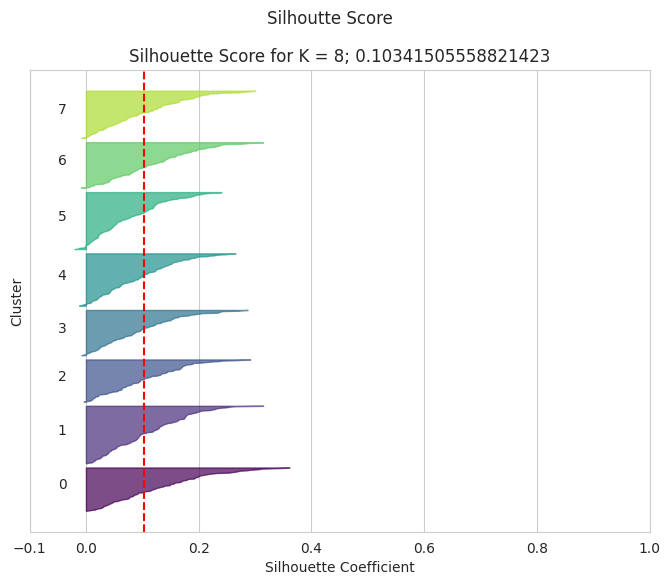

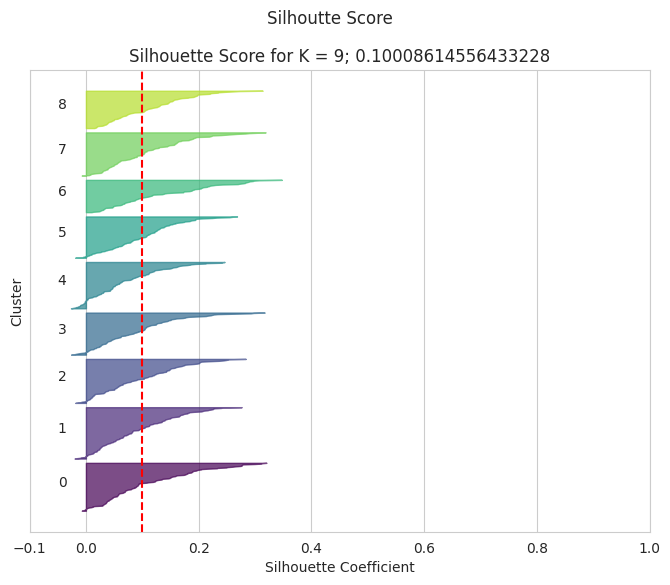

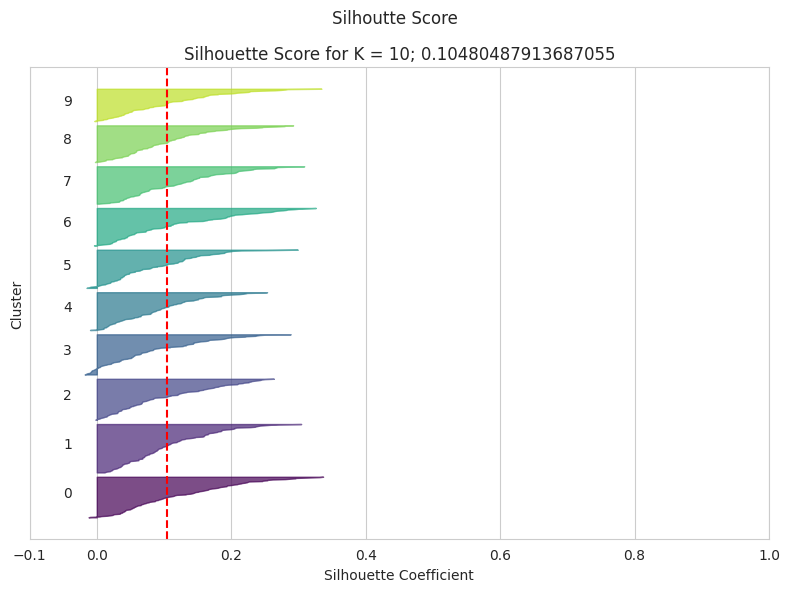

In [101]:
# Try silhoutte to get better number of clusters
silhoutte_scores = []

for i in range(2, 11):   # Trying K values from 2 to 10
  fig, axes = plt.subplots()
  fig.set_size_inches(8, 6)
  fig.suptitle('Silhoutte Score')

  # initiate KMeans
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  cluster_labels = kmeans.fit_predict(X_processed)

  # Calculate the silhoutte score for current cluster
  silhouette_avg = silhouette_score(X_processed, cluster_labels)
  print(f"For K = {i}, the average silhouette score is {silhouette_avg}")

  silhoutte_scores.append(silhouette_avg)

  # Calculate the silhouette score for each data point
  sample_silhouette_values = silhouette_samples(X_processed, cluster_labels)

  y_lower = 10
  for k in range(i):
    # Aggregate the silhouette scores for samples belonging to cluster k
    kth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == k]
    kth_cluster_silhouette_values.sort()

    size_cluster_k = kth_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_k

    color = plt.cm.viridis(float(k) / i)
    axes.fill_betweenx(np.arange(y_lower, y_upper), 0, kth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    axes.text(-0.05, y_lower + 0.5 * size_cluster_k, str(k))

    y_lower = y_upper + 10

  axes.set_title(f"Silhouette Score for K = {i}; {silhouette_avg}")
  axes.set_xlabel("Silhouette Coefficient")
  axes.set_ylabel("Cluster")

  # Add vertical line for average silhouette score of all the values
  axes.axvline(x=silhouette_avg, color="red", linestyle="--")

  axes.set_yticks([])
  axes.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

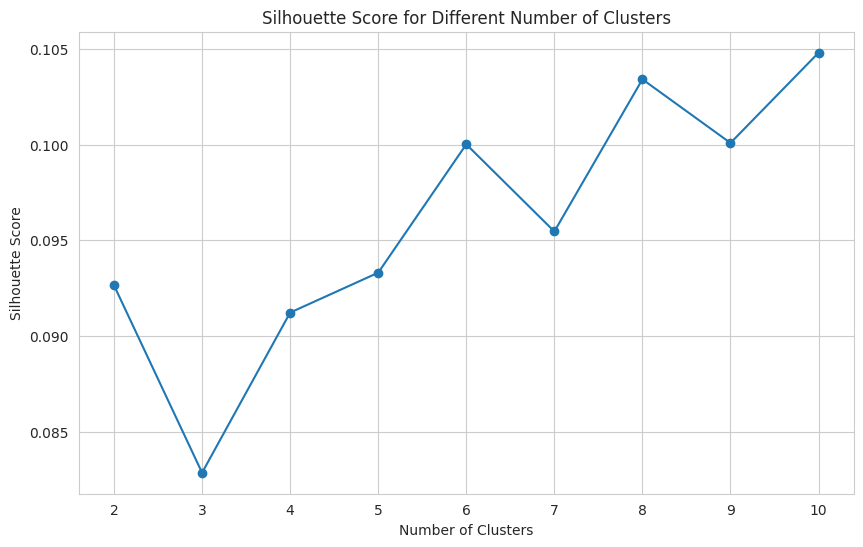

In [102]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhoutte_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.show()

In [103]:
## K-Means is not suitable for this data
## Let's do the test for K-Prototypes and DBSCAN

In [104]:
## start the K-Prototypes

In [105]:
df.drop(['gender', 'language'], axis=1, inplace=True)

In [106]:
df_topics_cat = df.loc[:, 'digital_marketing':]
df_cat = df.loc[:, ['age', 'location', 'education_level', 'device_usage', 'income_level']]
df_num = df.loc[:, ['likes_and_reactions', 'followed_accounts', 'time_spent_online_hrs_per_weekday', 'time_spent_online_hrs_per_weekend', 'click_through_rates_ctr', 'conversion_rates', 'ad_interaction_time_sec', 'num_interests']]

In [107]:
numerical_cols = df_num.columns

In [108]:
numerical_transformer = StandardScaler()
df_num_scaled = numerical_transformer.fit_transform(df_num)

# Convert the scaled array back to a DataFrame with original column names
df_num_scaled = pd.DataFrame(df_num_scaled, columns=numerical_cols)

In [109]:
df_cat = pd.get_dummies(df_cat, columns=df_cat.columns, drop_first=False).astype(int)
df_cat = pd.concat([df_cat, df_topics_cat], axis=1)
df_cat.columns = df_cat.columns.str.lower().str.replace(' + ', '_').str.replace(' ', '_').str.replace('-', '_').str.replace('+', '').str.replace('[()]', '', regex=True).str.replace('/', '_per_')
categorical_cols = df_cat.columns

In [110]:
df_transformed = pd.concat([df_num_scaled, df_cat], axis=1)
categorical_indices = [df_transformed.columns.get_loc(col) for col in categorical_cols]

X = df_transformed.values

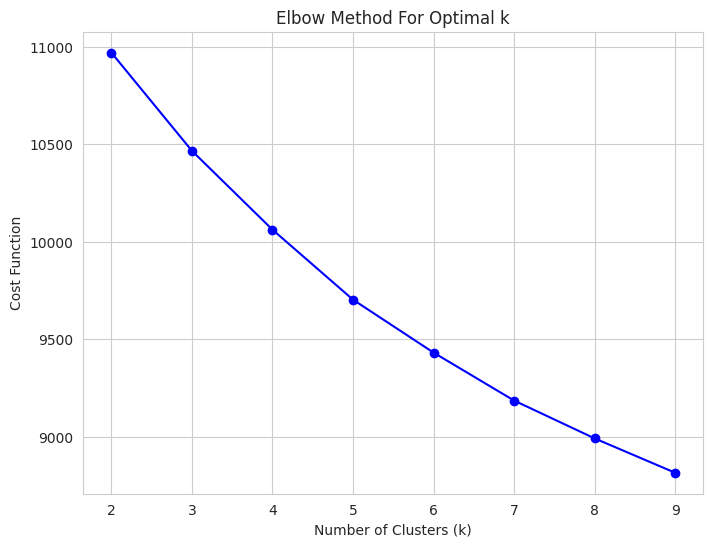

In [111]:
cost = []
for k in range(2, 10):
  try:
    kp = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    clusters = kp.fit_predict(X, categorical=categorical_indices)
    cost.append(kp.cost_)
  except:
    continue

plt.figure(figsize=(8, 6))
plt.plot(range(2, len(cost) + 2), cost, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost Function')
plt.title('Elbow Method For Optimal k')
plt.show()

In [112]:
kp3 = KPrototypes(n_clusters=3, init='Cao', verbose=0)
clusters3 = kp3.fit_predict(X, categorical=categorical_indices)

In [113]:
kp4 = KPrototypes(n_clusters=4, init='Cao', verbose=0)
clusters4 = kp4.fit_predict(X, categorical=categorical_indices)

In [114]:
df['cluster_3'] = clusters3
# df['cluster_4'] = clusters4
# df.to_csv('drive/MyDrive/UPS/user_profiles_for_ads_result.csv')

In [8]:
df = pd.read_csv('drive/MyDrive/UPS/user_profiles_for_ads_result.csv')

In [9]:
cluster_age_counts = df.groupby(['cluster_3', 'income_level'])['user_id'].count().reset_index()
cluster_age_counts = cluster_age_counts.rename(columns={'user_id': 'count'})
display(cluster_age_counts)

,cluster_3,income_level,count
0,0,0-20k,51
1,0,100k+,56
2,0,20k-40k,59
3,0,40k-60k,52
4,0,60k-80k,63
5,0,80k-100k,65
6,1,0-20k,54
7,1,100k+,57
8,1,20k-40k,49
9,1,40k-60k,69


Text(0.5, 0, 'Cluster')

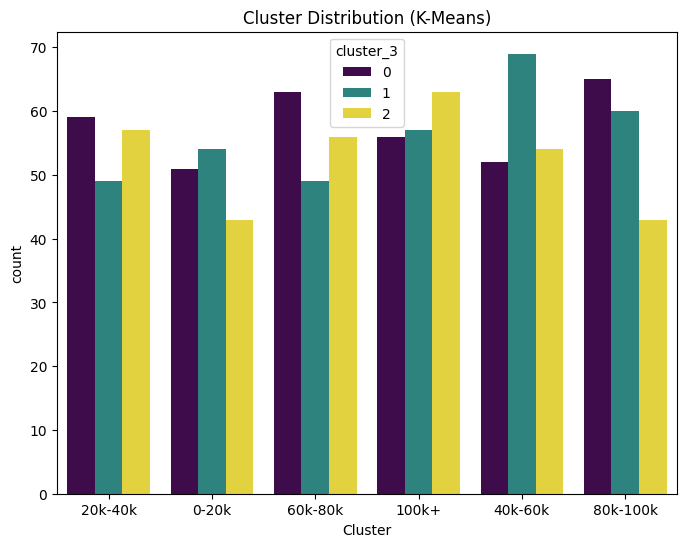

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='income_level', data=df, hue='cluster_3', palette='viridis')
plt.title('Cluster Distribution (K-Means)')
plt.xlabel('Cluster')

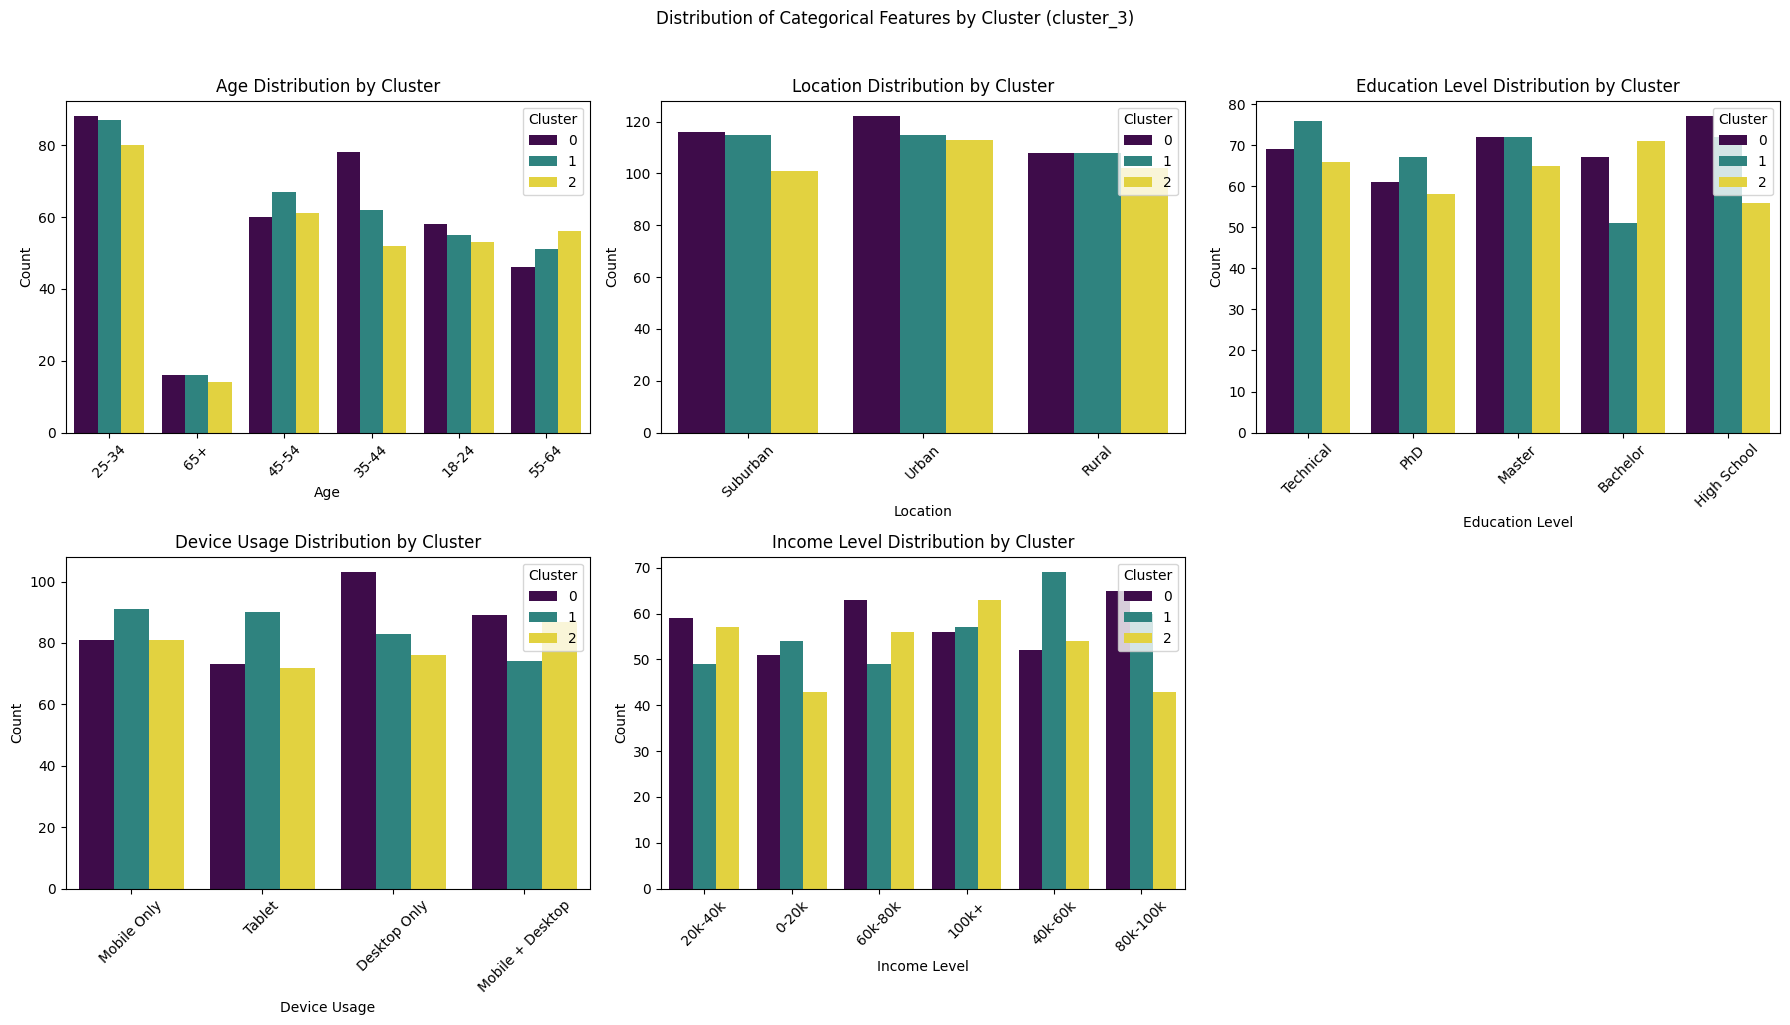

In [11]:
# Define the categorical columns to plot
categorical_cols_to_plot = ['age', 'location', 'education_level', 'device_usage', 'income_level']

# Create subplots
n_cols = 3 # Adjust the number of columns as needed
n_rows = (len(categorical_cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
fig.suptitle('Distribution of Categorical Features by Cluster (cluster_3)', y=1.02)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each categorical column and create a bar plot showing distribution across clusters
for i, col in enumerate(categorical_cols_to_plot):
  sns.countplot(x=col, hue='cluster_3', data=df, ax=axes[i], palette='viridis')
  axes[i].set_title(f'{col.replace("_", " ").title()} Distribution by Cluster')
  axes[i].set_xlabel(col.replace("_", " ").title())
  axes[i].set_ylabel("Count")
  axes[i].tick_params(axis='x', rotation=45)
  axes[i].legend(title='Cluster')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

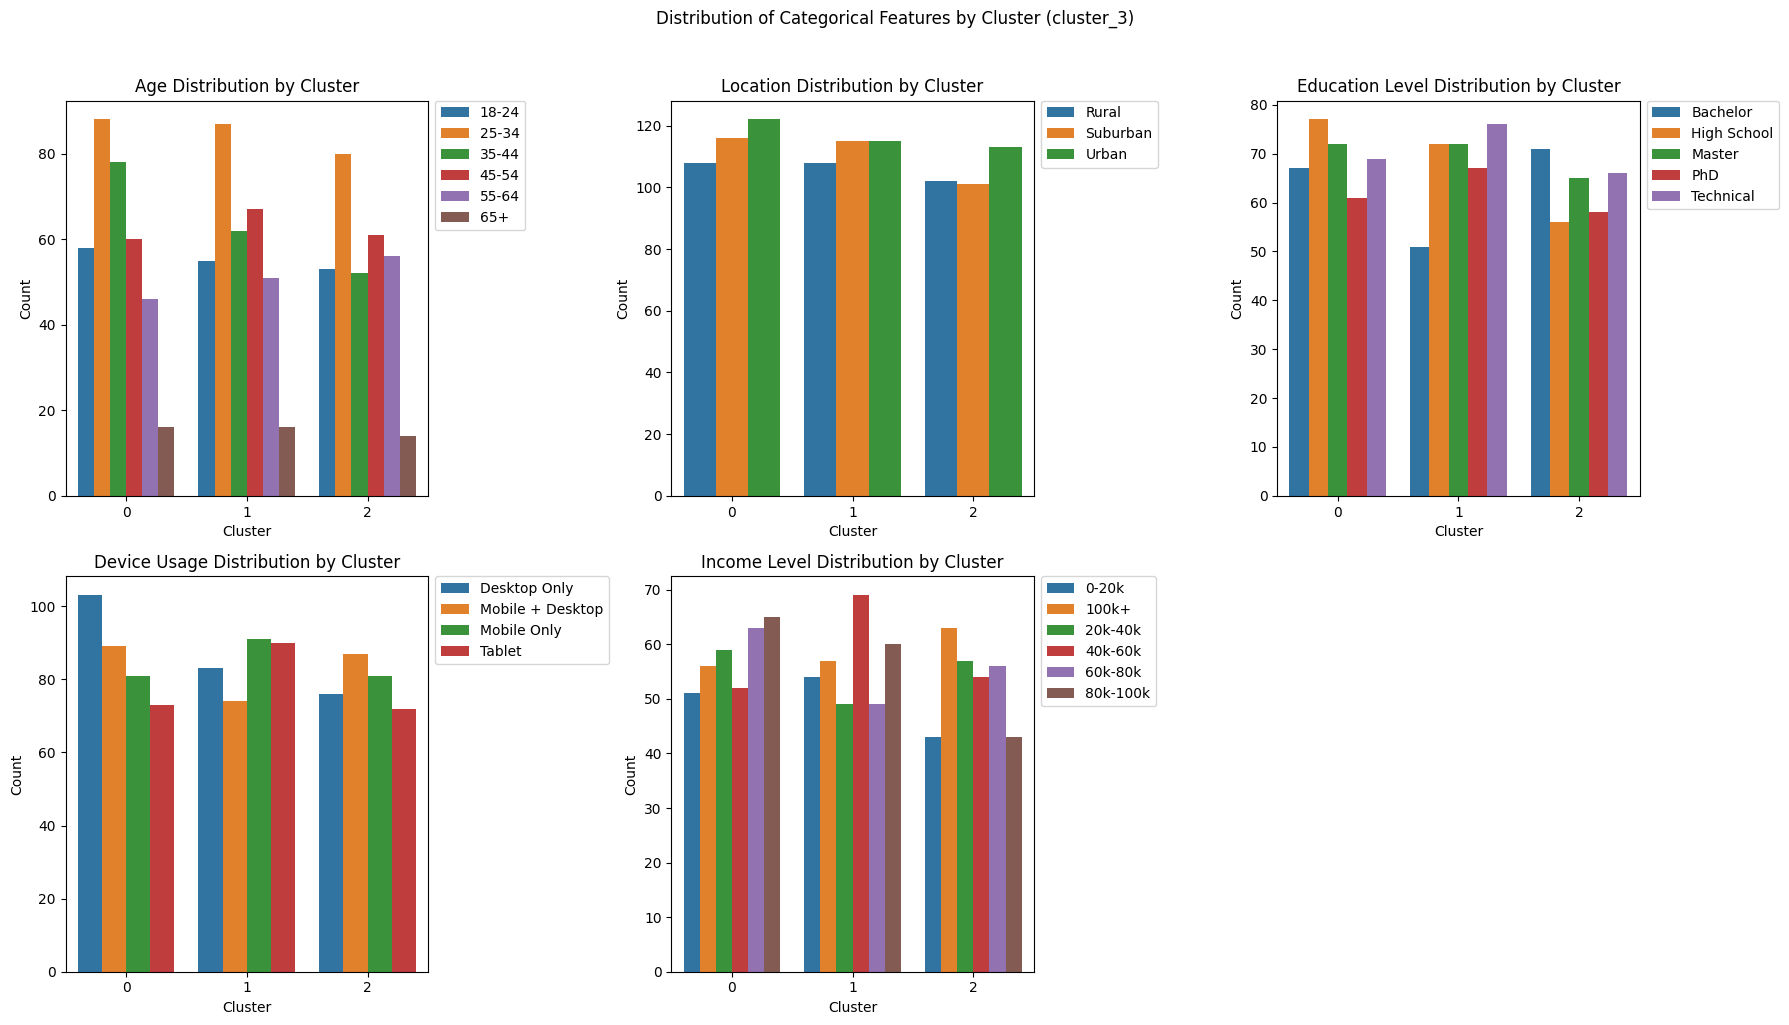

In [12]:
# Define the categorical columns to plot
categorical_cols_to_plot = ['age', 'location', 'education_level', 'device_usage', 'income_level']

# Create subplots
n_cols = 3 # Adjust the number of columns as needed
n_rows = (len(categorical_cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
fig.suptitle('Distribution of Categorical Features by Cluster (cluster_3)', y=1.02)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each categorical column and create a bar plot showing distribution across clusters
for i, col in enumerate(categorical_cols_to_plot):
  # Sort the categories
  sorted_categories = sorted(df[col].unique())
  sns.countplot(x='cluster_3', hue=col, data=df, ax=axes[i], palette='tab10', order=[0,1,2], hue_order=sorted_categories)
  axes[i].set_title(f'{col.replace("_", " ").title()} Distribution by Cluster')
  axes[i].set_xlabel('Cluster')
  axes[i].set_ylabel("Count")
  axes[i].tick_params(axis='x', rotation=0)
  axes[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
num_bins = 4
bins = np.linspace(df['num_interests'].min(), df['num_interests'].max(), num_bins + 1)
histogram_table = df.groupby('cluster_3')['num_interests'].apply(lambda x: np.histogram(x, bins=bins)[0])
histogram_table = pd.DataFrame(histogram_table.tolist(), index=histogram_table.index, columns=[f'bin_{i+1}' for i in range(num_bins)])
display(histogram_table)

,bin_1,bin_2,bin_3,bin_4
cluster_3,,,,
0,3,34,131,178
1,72,108,99,59
2,150,125,39,2


Text(0.5, 0, 'Cluster')

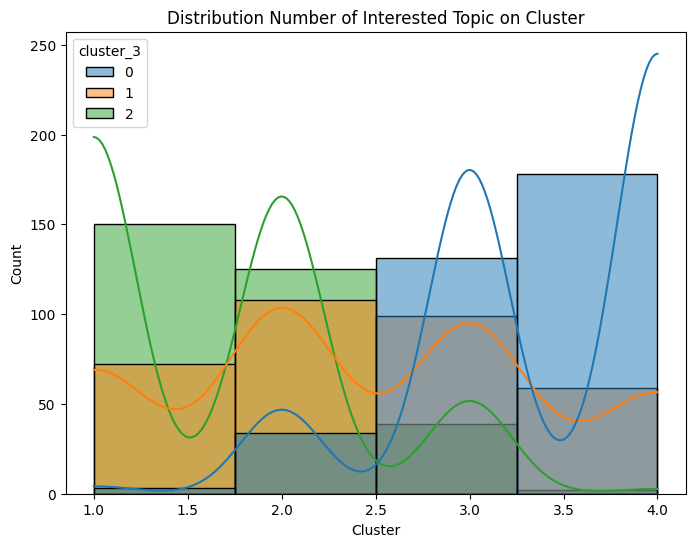

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(x='num_interests', data=df, hue='cluster_3', palette='tab10', kde=True, bins=4)
plt.title('Distribution Number of Interested Topic on Cluster')
plt.xlabel('Cluster')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

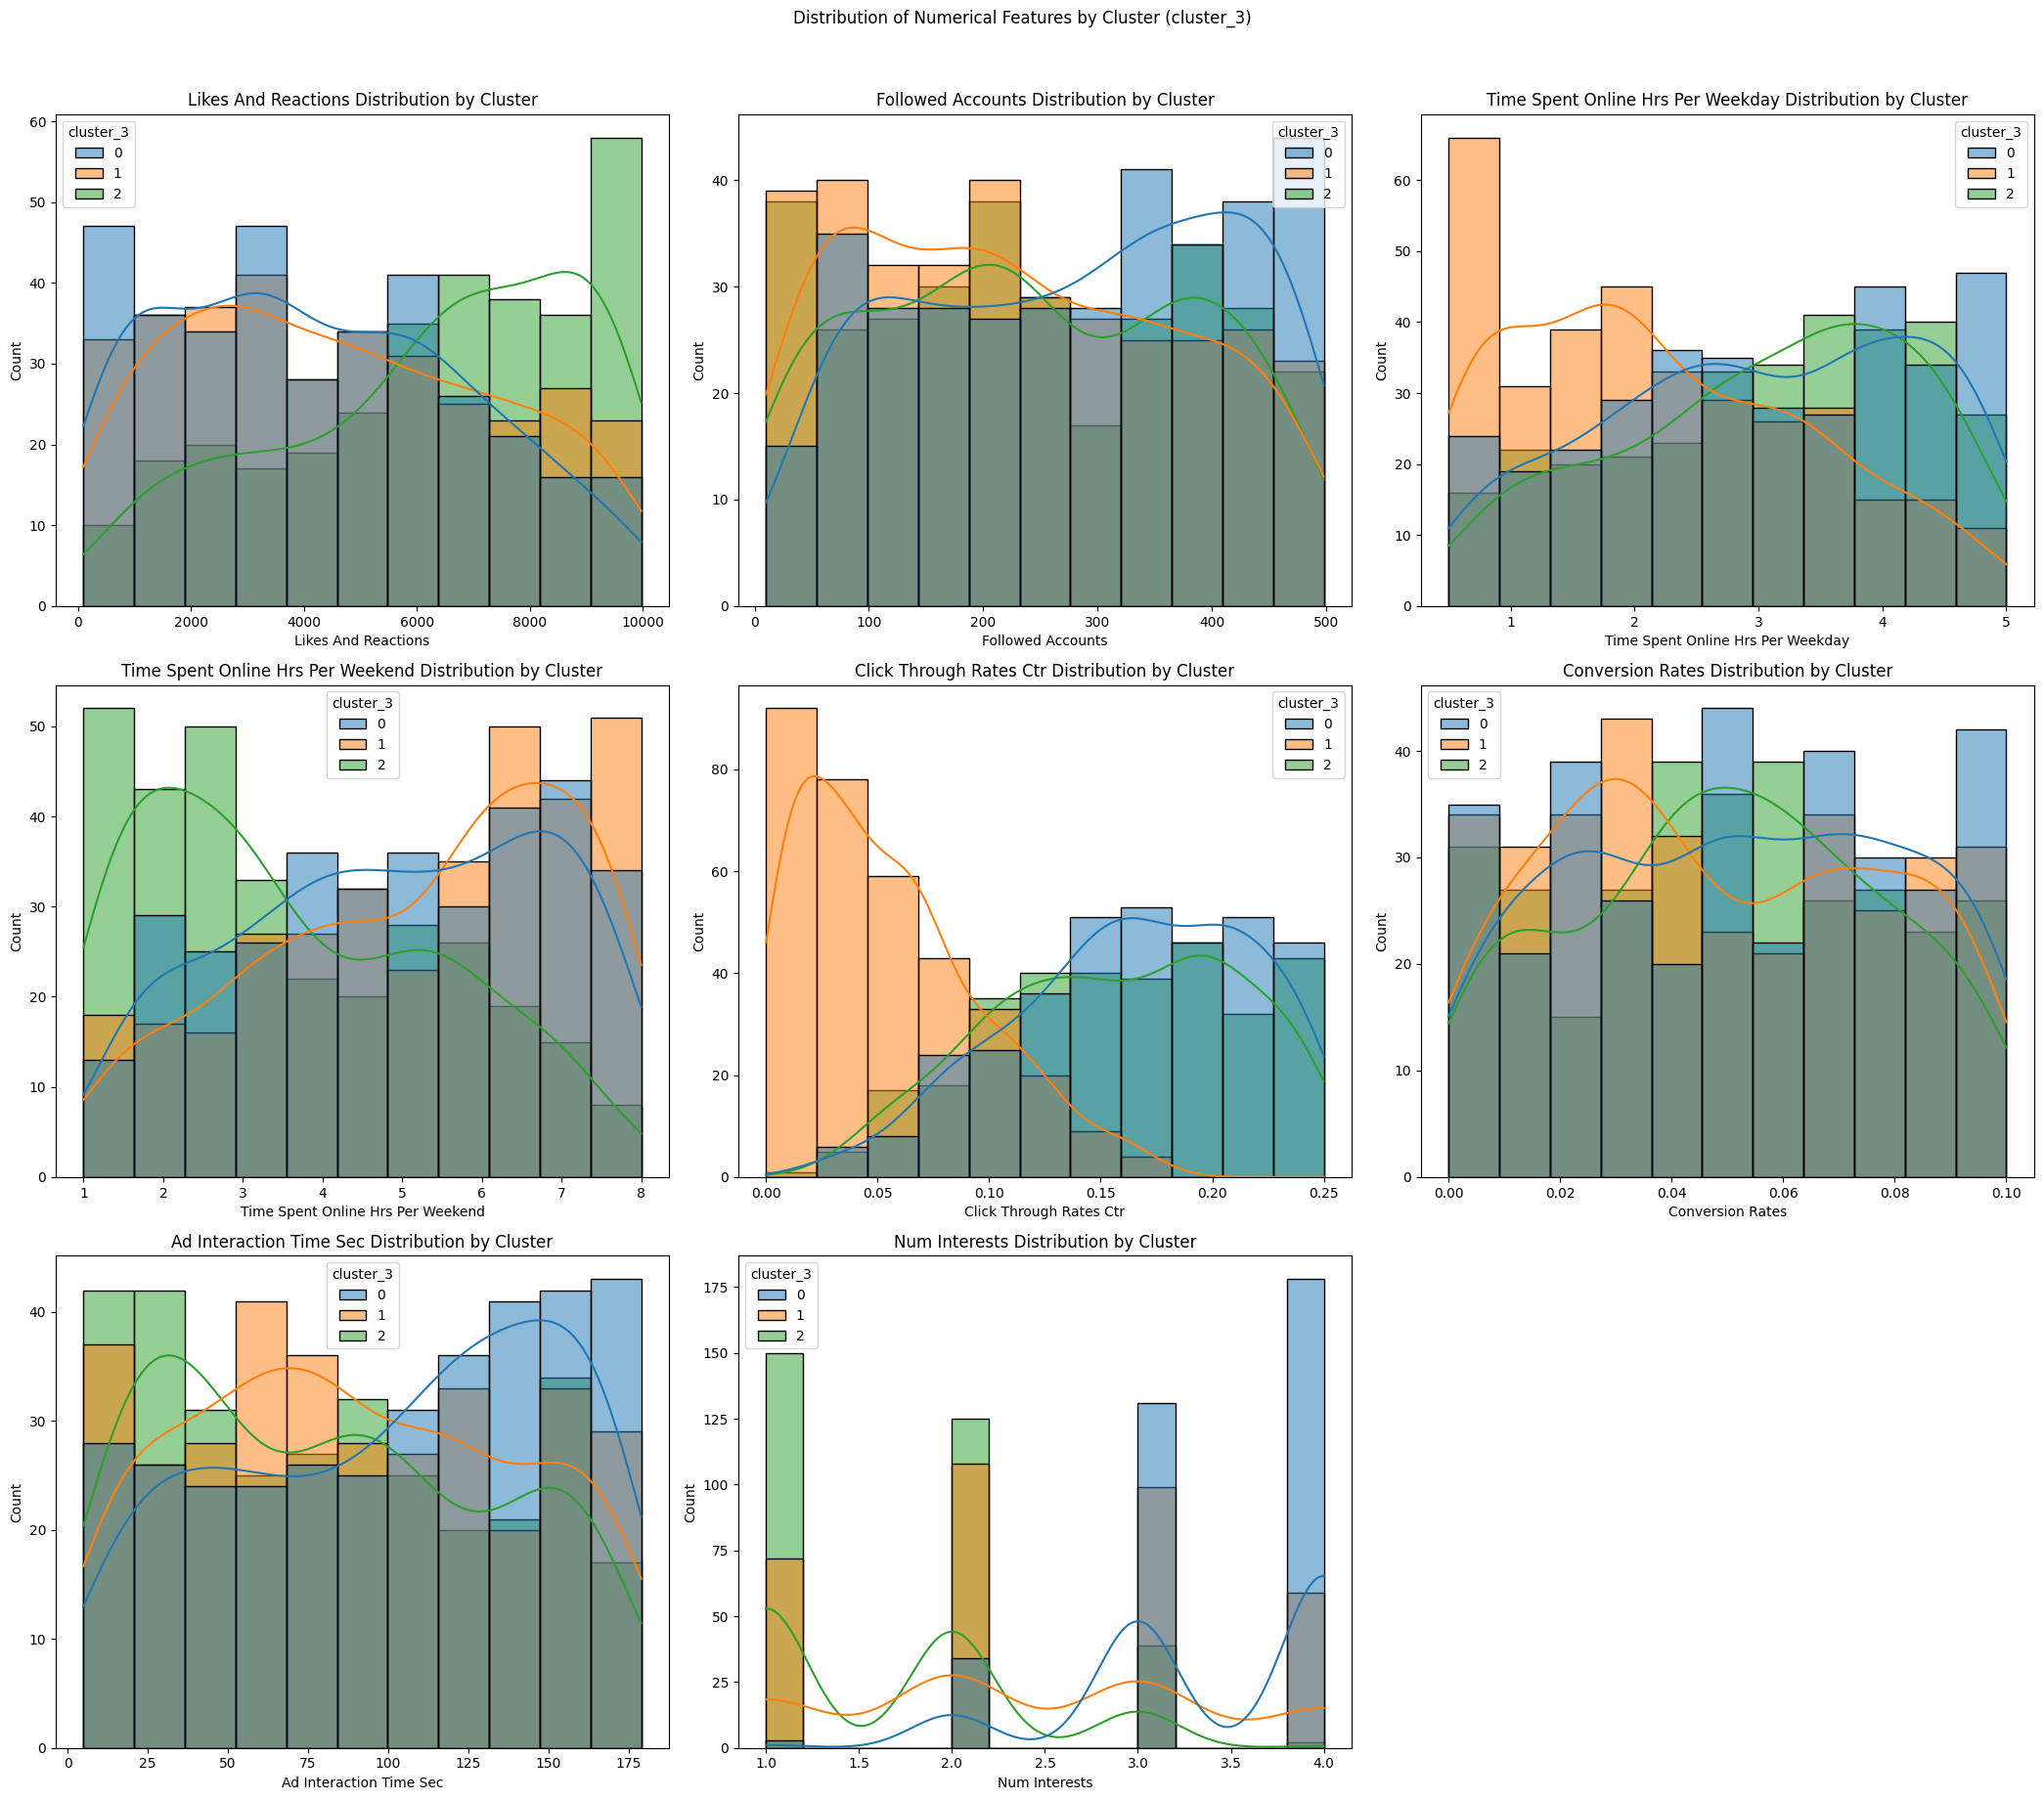

In [15]:
df_ = df.copy()
df_ = df_.loc[:, 'age':'num_interests']
numerical_cols_to_plot = df_.select_dtypes(exclude='object').columns

# Create subplots
n_cols = 3 # Adjust the number of columns as needed
n_rows = (len(numerical_cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 6))
fig.suptitle('Distribution of Numerical Features by Cluster (cluster_3)', y=1.02)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each numerical column and create a histogram showing distribution across clusters
for i, col in enumerate(numerical_cols_to_plot):
  sns.histplot(x=col, hue='cluster_3', data=df, ax=axes[i], kde=True, palette='tab10')
  axes[i].set_title(f'{col.replace("_", " ").title()} Distribution by Cluster')
  axes[i].set_xlabel(col.replace("_", " ").title())
  axes[i].set_ylabel("Count")
  # axes[i].legend(title='Cluster') # Make legend font size larger

# Hide any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

ValueError: Could not interpret value `cluster_4` for `hue`. An entry with this name does not appear in `data`.

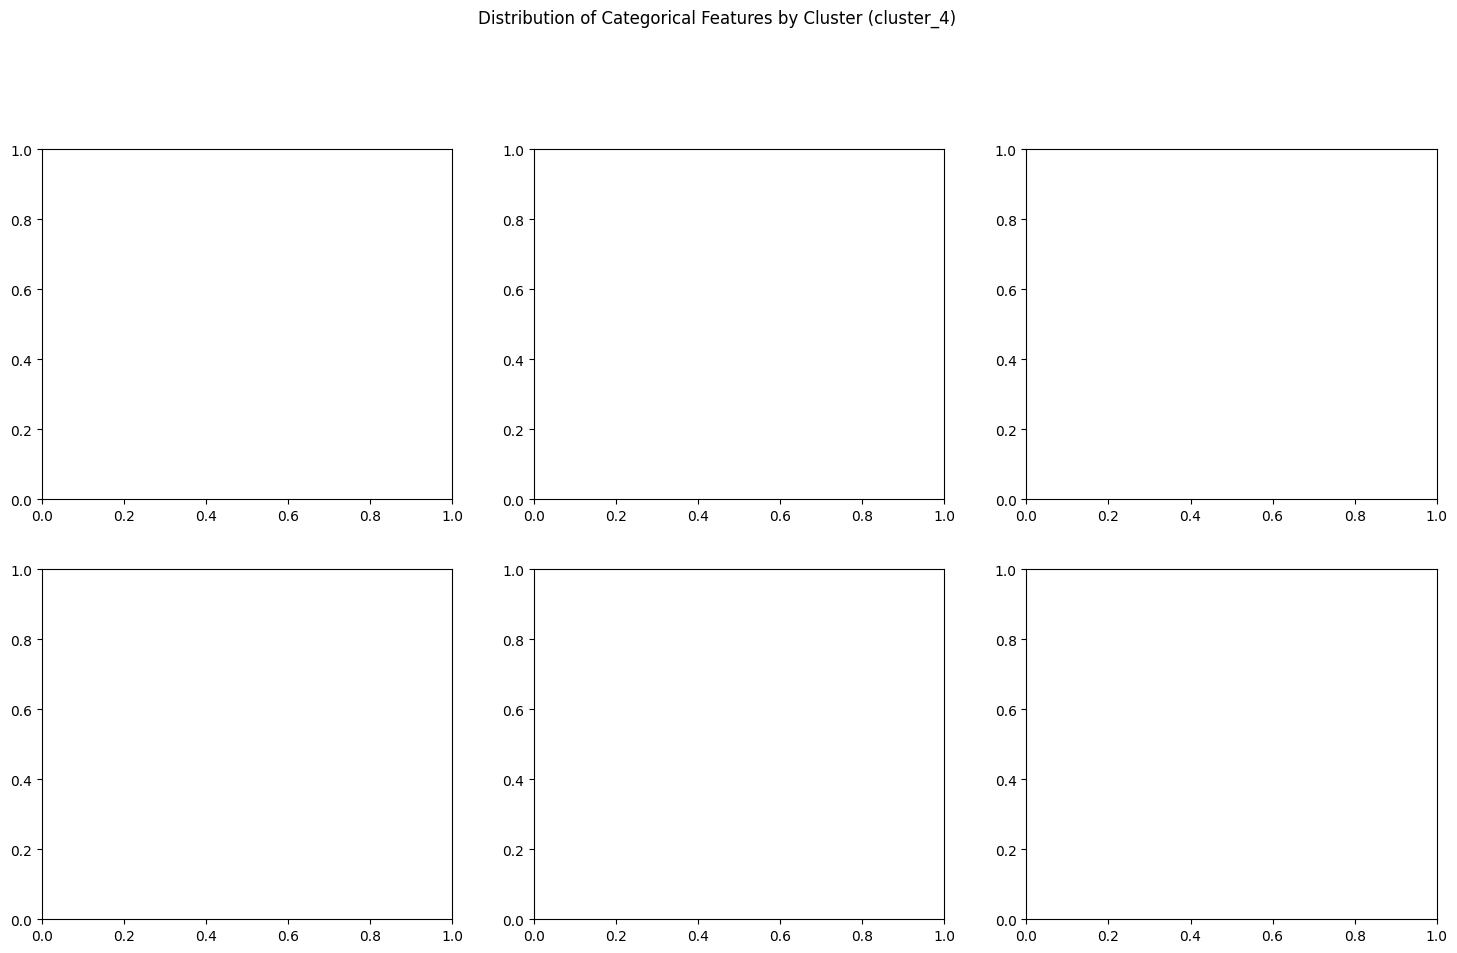

In [16]:
# Define the categorical columns to plot
categorical_cols_to_plot = ['age', 'location', 'education_level', 'device_usage', 'income_level']

# Create subplots
n_cols = 3 # Adjust the number of columns as needed
n_rows = (len(categorical_cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
fig.suptitle('Distribution of Categorical Features by Cluster (cluster_4)', y=1.02)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each categorical column and create a bar plot showing distribution across clusters
for i, col in enumerate(categorical_cols_to_plot):
  sns.countplot(x=col, hue='cluster_4', data=df, ax=axes[i], palette='viridis')
  axes[i].set_title(f'{col.replace("_", " ").title()} Distribution by Cluster')
  axes[i].set_xlabel(col.replace("_", " ").title())
  axes[i].set_ylabel("Count")
  axes[i].tick_params(axis='x', rotation=45)
  axes[i].legend(title='Cluster')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

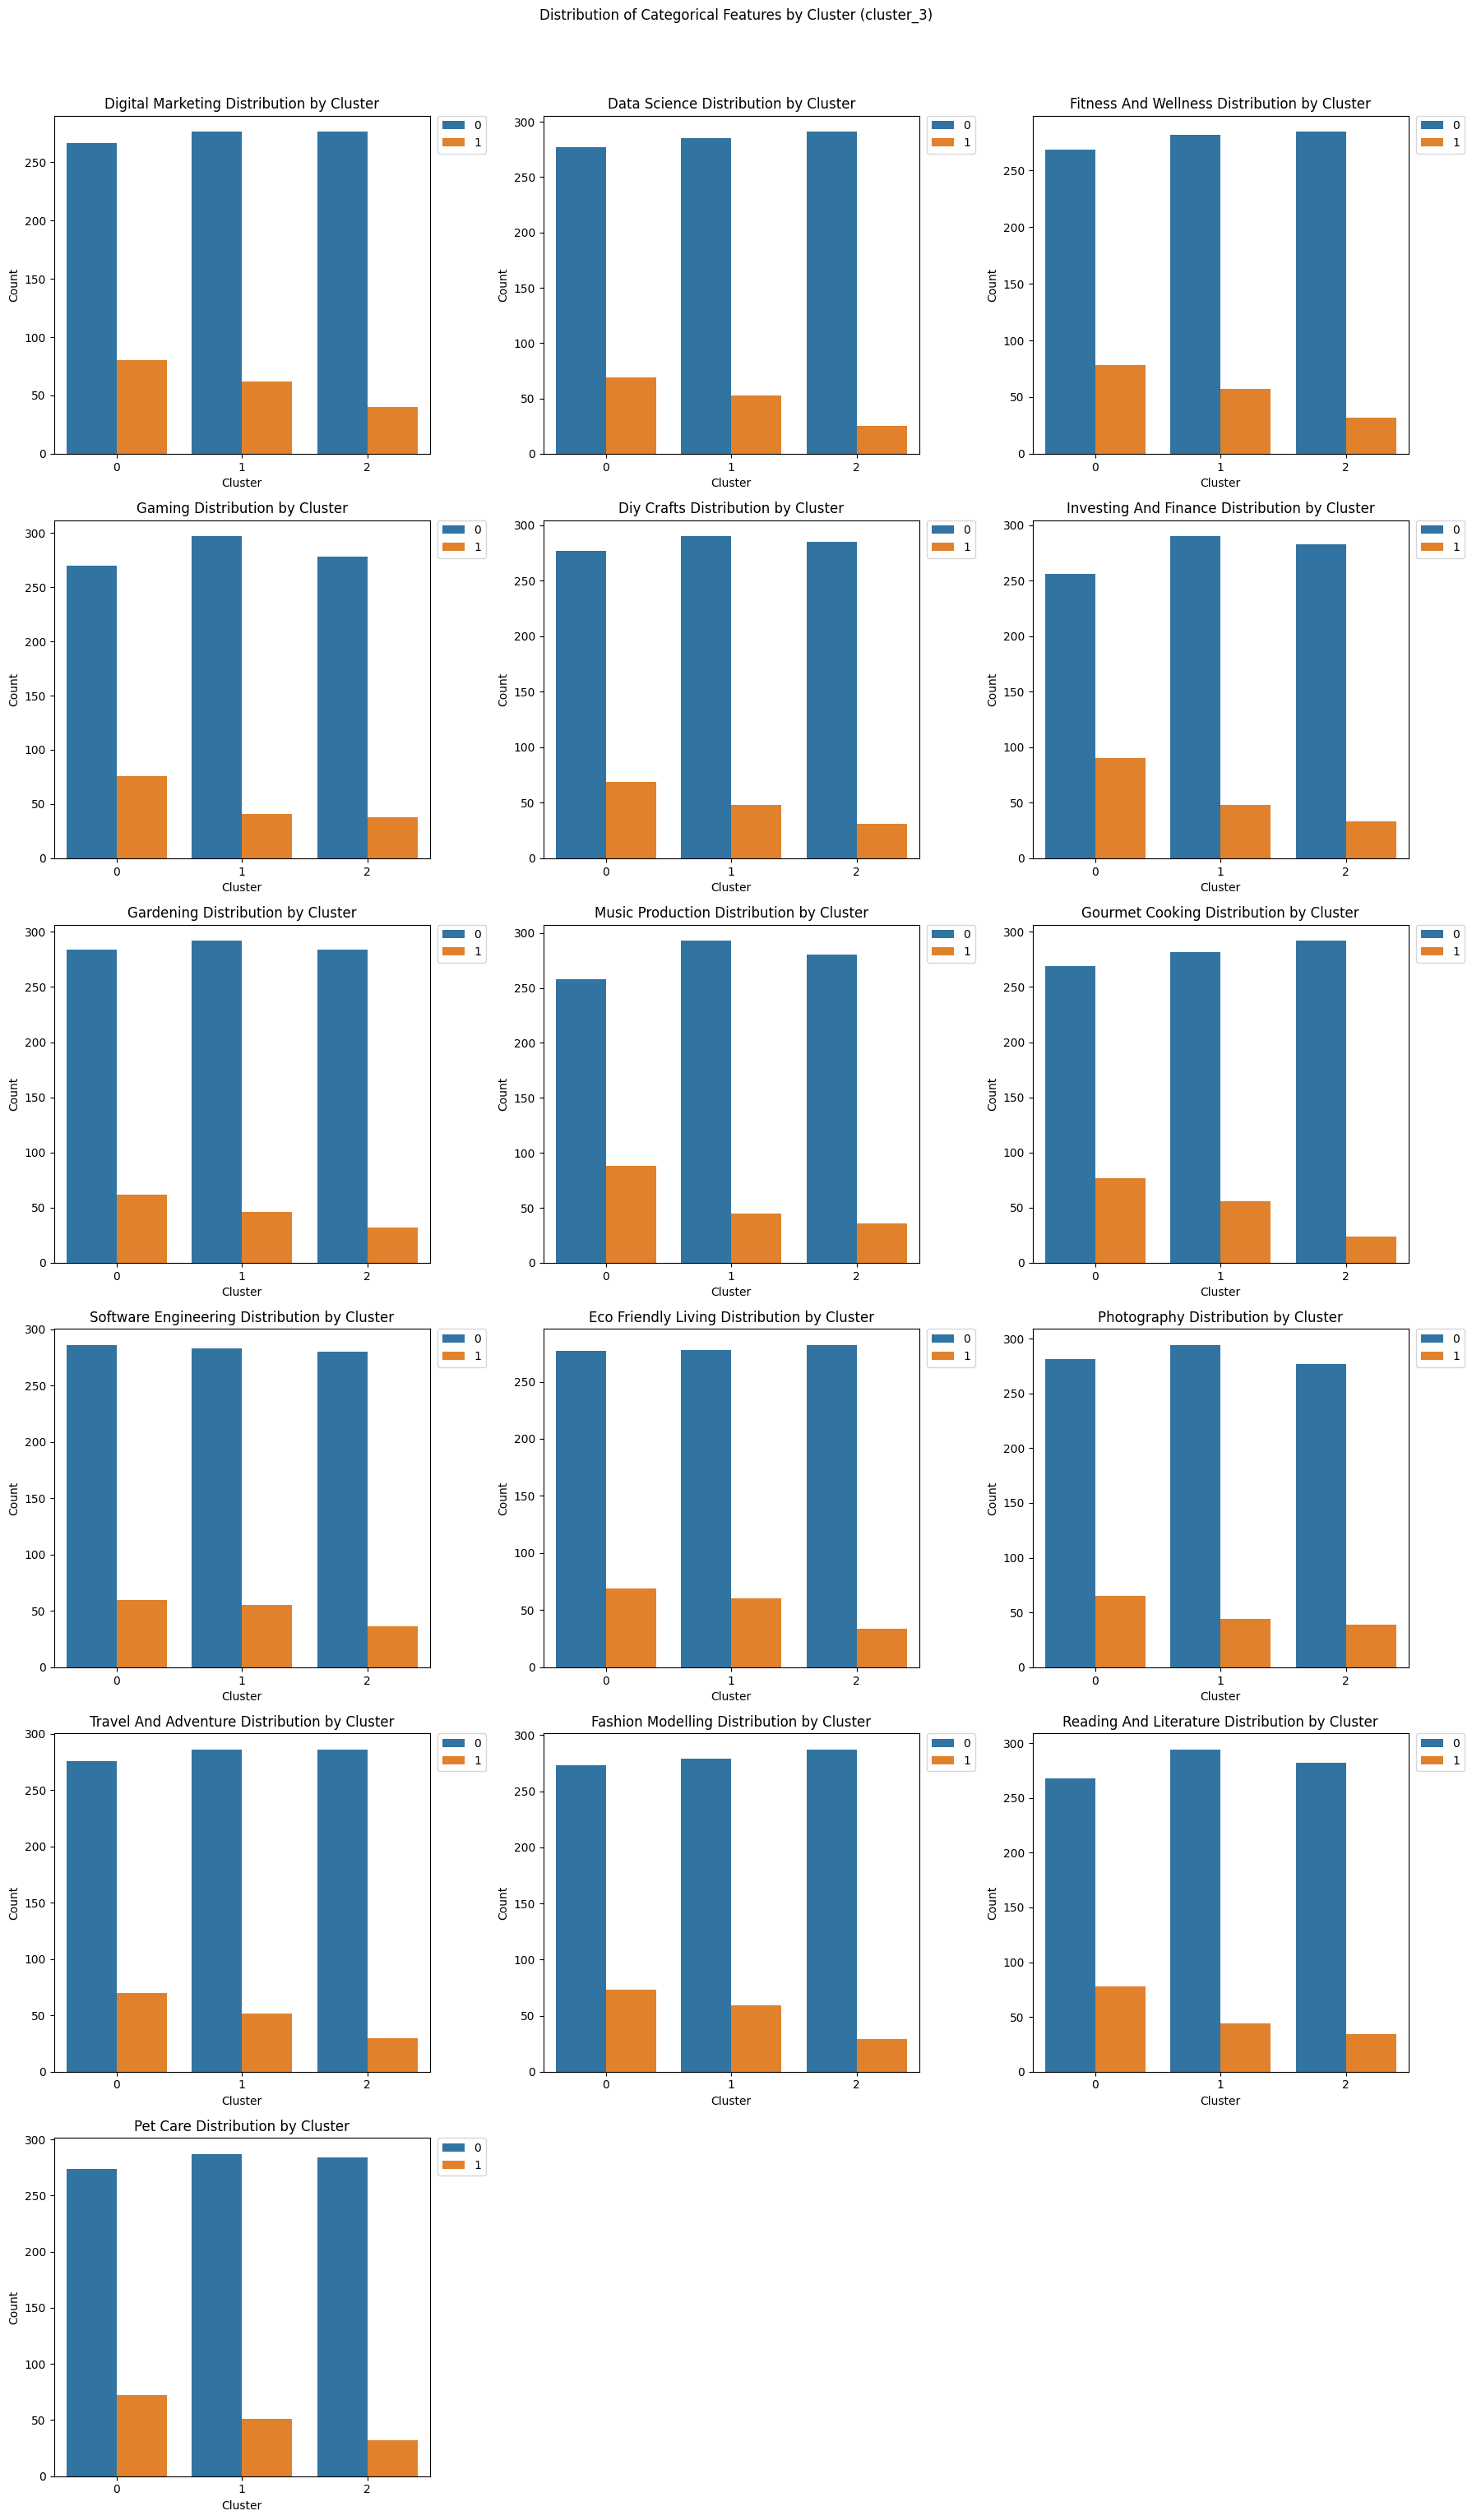

In [17]:
# Define the categorical columns to plot
categorical_cols_to_plot = list(df.loc[:, 'digital_marketing':'pet_care'].columns)

# Create subplots
n_cols = 3 # Adjust the number of columns as needed
n_rows = (len(categorical_cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
fig.suptitle('Distribution of Categorical Features by Cluster (cluster_3)', y=1.02)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each categorical column and create a bar plot showing distribution across clusters
for i, col in enumerate(categorical_cols_to_plot):
  # Sort the categories
  sorted_categories = sorted(df[col].unique())
  sns.countplot(x='cluster_3', hue=col, data=df, ax=axes[i], palette='tab10', order=[0,1,2], hue_order=sorted_categories)
  axes[i].set_title(f'{col.replace("_", " ").title()} Distribution by Cluster')
  axes[i].set_xlabel('Cluster')
  axes[i].set_ylabel("Count")
  axes[i].tick_params(axis='x', rotation=0)
  axes[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
cluster_digital_marketing_counts = df.groupby(['cluster_3', 'pet_care'])['user_id'].count().reset_index()
cluster_digital_marketing_counts = cluster_digital_marketing_counts.rename(columns={'user_id': 'count'})
display(cluster_digital_marketing_counts)

## Conclusion
### Cluster-0: Engaged Urban Professionals
This cluster is defined by its high level of online engagement and diverse interests. Users in this group spend more time interacting with ads and have the highest conversion rates, indicating that they are not only active but also highly receptive to advertising. Demographically, they are predominantly young to middle-aged adults (25−44 years old) with a wide range of educational backgrounds and higher income levels, with a significant portion earning over $80k. They are most likely to live in urban areas and primarily use desktop devices.

Their online behavior is characterized by a high number of followed accounts and frequent likes and reactions. This group's interests are broad and span a variety of topics, showing the highest interest levels across all categories. Their top interests include:

- Investing and Finance (26.01%)

- Music Production (25.43%)

- Digital Marketing (23.12%)

- Gourmet Cooking (22.25%)

- Fitness and Wellness (22.54%)

- Gaming (21.97%)

- Reading and Literature (22.54%)

### Cluster-1: Information Seekers
Users in this cluster are characterized by a high click-through rate (CTR), meaning they frequently click on ads, but have a lower interaction time and conversion rate compared to Cluster 0. This behavior suggests they are curious and actively seek out information, but are more selective about their purchases. This group has a balanced age distribution, with a slight concentration in the 25−34 age group. Their education and income levels are diverse, and they are evenly distributed across different locations and device types, though they show a slight preference for mobile-only usage.

Their online presence is very active, with a high number of followed accounts. While they are interested in various topics, their interest levels are more moderate compared to Cluster 0. Their top interests include:

- Digital Marketing (18.34%)

- Eco-Friendly Living (17.75%)

- Fashion Modelling (17.46%)

- Gourmet Cooking (16.57%)

- Software Engineering (16.27%)

- Pet Care (15.09%)

- Travel and Adventure (15.38%)

### Cluster-2: Mobile-First Passive Users
This cluster shows the lowest overall engagement with ads, as indicated by a lower CTR and less time spent on ads. This group is also well-distributed across age groups, with a notable number of older users (55−64 years old). They primarily use a combination of mobile and desktop devices. They have a lower number of followed accounts and lower likes and reactions, suggesting a more passive or selective online presence. Their income and educational backgrounds are varied.

This group has the most focused interests, with the majority of users following only one or two topics. Their interest levels across all specific topics are consistently the lowest among the three clusters. Their online activity is also more moderate compared to the other clusters, with more activity on weekdays and less on weekends.